# Quantum machine learning in Amazon Braket Hybrid Jobs

This notebook demonstrates a typical quantum machine learning workflow, including uploading data, monitoring training, and tuning hyperparameters. We focus on training a parameterized quantum circuit for an unsupervised generative modelling task.


## Learning outcomes

* Set input data 
* Set hyperparameters 
* Submit multiple jobs asynchronously 
* Monitor job progress via the AWS Console 
* Download and plot results

## Background: Generative modelling 

Generative modelling is an unsupervised learning task where the goal is to generate new synthetic samples from an unknown target probability distribution. We denote the target probability distribution as $p(x)$, and the estimated distribution as $p_{\theta}(x)$. The goal is to learn $p_{\theta}(x)$ that closely resembles the target $p(x)$.  One metric to quantify the difference between probability distributions is the maximum mean discrepancy (MMD) loss . 

$$MMD(x, y) = \sum_{j=1}^N \sum_{j'=1}^N k(y_j, y_{j'}) + \sum_{i=1}^N \sum_{i'=1}^N k(x_i, x_{i'})  - 2 \sum_{j=1}^N \sum_{i=1}^N k(y_j, x_i)$$
where $x$ is a sample from the target data $p(x)$, $y$ is a sample from the generative model $p_{\theta}(x)$, and $k$ is a Gaussian kernel

$$ k(x,y)= \sum_{\sigma} e^{-(x-y)^2/(2 \sigma^2))}$$

The MMD loss is zero if and only if $p(x)=p_{\theta}(x)$ for all $x$. 

Learning a good approximation $p_{\theta}$ depends on the expressibility of the model, the effectiveness of the training algorithm, and the ability to sample the circuit efficiently. 


## Quantum Circuit Born Machine 

Quantum circuits are a natural fit for generative modelling because they are inherently probabilistic; the wavefunction encodes a probability according to the Born rule:

$$p(x)=|\langle x|\psi\rangle|^2$$

In quantum mechanics, we do not have access to $p(x)$ directly, but we can efficiently sample using projective measurements [1]. This is an implicit generative model similar to generative adversarial networks (GANs). Quantum circuits allow fast sampling from a high-dimension distribution, and have large expressive power. 

The QCBM in this tutorial consists of alternating layers of single qubit rotations ($RX, RZ, RX$), followed by an entangling layer of CNot gates on each neighboring qubits. The final measurement layer computes the bit string samples of each outcome. Run the cell below to print a circuit diagram of a QCBM with randomly initialized parameters.


In [1]:
from braket.devices import LocalSimulator
from qcbm.qcbm import QCBM
import numpy as np

n_qubits = 3
n_layers = 1
init_params = np.random.rand(3 * n_layers * n_qubits)
device = LocalSimulator()
qcbm = QCBM(device, n_qubits, n_layers, np.random.rand(1))
print(qcbm.create_circuit(init_params))

T  : |     0     |    1    |    2     |3|4|5|Result Types|
                                                          
q0 : -Rx(0.875)---Rz(0.321)-Rx(0.449)--C---X-Probability--
                                       |   | |            
q1 : -Rx(0.872)---Rz(0.615)-Rx(0.0769)-X-C-|-Probability--
                                         | | |            
q2 : -Rx(0.00923)-Rz(0.352)-Rx(0.942)----X-C-Probability--

T  : |     0     |    1    |    2     |3|4|5|Result Types|


## Problem setup

This notebook demonstrates training a QCBM on a toy data set using Amazon Braket Hybrid Jobs. The code for the QCBM is in `qcbm` directory. The `qcbm_job.py` contains the code that will run when we create a Braket Job. The other file (`qcbm.py`) contain the source code for the QCBM. 

In this tutorial, we use a small number of qubits to make it quick to test the algorithm. We use the on-demand simulator SV1 to run our circuits and gradient calculations in parallel (up to 35 concurrent tasks).  

We first set the number of qubits we want to use in our problem:

In [2]:
n_qubits = 5

## Generate data

As an example, we consider the toy example of learning a mixture of Gaussian distributions. We set a numpy random seed to produce the same data each time, but try experimenting with the number of peaks and number of qubits to produce harder or easier data sets. For this example, the target distribution $p(x)$ is a Gaussian on 5 bits (so $2^5$ possible values), with peaks at $\mu_1=7$ and $\mu_2=20$, with standard deviations $\sigma_1=1$, $\sigma_2 = 2$. We generate and plot the data as a probability density function in the cell below.

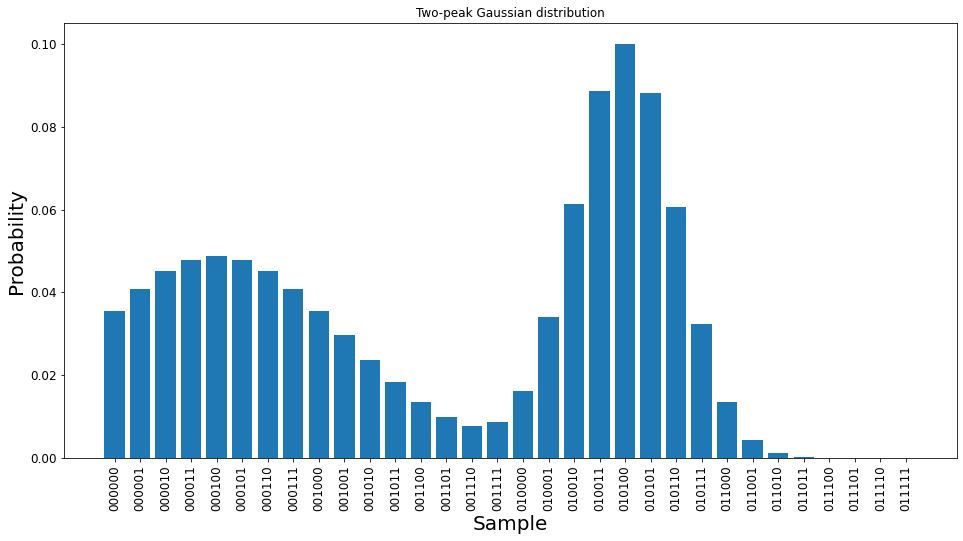

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

def gaussian(n_qubits, mu, sigma=1):
    x = np.arange(2 ** n_qubits)
    gaussian = (
        1.0
        / np.sqrt(2 * np.pi * sigma ** 2)
        * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    )
    return gaussian / sum(gaussian)


data = gaussian(n_qubits, mu=4, sigma=5) + gaussian(n_qubits, mu=20, sigma=2)
data = data / sum(data)


labels = ["{0:{fill}6b}".format(i, fill='0') for i in range(len(data))]

plt.bar(range(2 ** n_qubits), data)
plt.xticks([i for i in range(len(data))], labels, rotation='vertical', size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)
plt.title("Two-peak Gaussian distribution")

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [4]:
np.save("data.npy", data) # save data to file

# Upload data

To run our algorithm as a Hybrid Job, we need to input the data to the job. There are two primary ways to pass data to a Braket Job.

1. Firstly, we could pass the name of a local file as a string. In this example, it would be "data.npy". In the algorithm script (`qcbm_job.py`), we would then load the file with `f"{input_dir}/input/data.npy"` since `"input"` is the default S3 channel used by Braket Jobs. We create the job with 

```
        AwsQuantumJob(input_data="data.npy",...)
```


2. Secondly, we could directly upload the data to S3 and point the job to that bucket. In the cell below, we provide a utility function that uploads the data to S3 with the name `filename` under the directory `dir_name` in the default bucket. Optionally, we can pass a specific AwsSession to customize where the data is saved. The S3 path would be passed to create a job similarly:

```
        AwsQuantumJob(input_data=s3_path,...)
```



In [5]:
# Upload dataset to S3
from braket.aws import AwsSession

def setup_input_stream(data, filename, dir_name="job-data", aws_session=AwsSession()):
    stream_s3_uri = aws_session.construct_s3_uri(aws_session.default_bucket(), dir_name)
    np.save(filename, data)
    path = f"{stream_s3_uri}/" + filename
    aws_session.upload_to_s3(filename, path)
    return path

In [6]:
s3_path = setup_input_stream(data, "data.npy")
print(s3_path)

s3://amazon-braket-<region>-<account-id>/job-data/data.npy


As a double check, try navigating to this S3 bucket using the AWS Console to verify the data was successfully uploaded.

## Hyperparameters 

Next, we set the hyperparameters for our training job. To keep it simple, we only consider the following hyperparameters: number of qubits `n_qubits`, number of layers in the QCBM `n_layers`, and the number of iterations in the optimization algorithm.

The number of layers determines how many parameters are in the quantum circuit. For the QCBM, we need `n_params = 3 * n_layers * n_qubits`.

Note that the hyperparameters are defined in a Python dictionary of strings. Within the `qcbm_job.py` script, we will need to convert from strings back into integers.


In [7]:
# Declare hyperparameters for QCBM

n_iterations = 10
n_layers = 3

hyperparams = {
    "n_qubits": str(n_qubits),
    "n_layers": str(n_layers),
    "n_iterations": str(n_iterations)
}

We are now prepared to run a fully-managed Hybrid Job to keep track of our experiments and scale up to larger models. 

## Creating a Braket Job

The `AwsQuantumJob.create()` function requires a few arguments. 


* `device`:  Specifies the device we wish to run on. In this tutorial, we will use the Amazon Braket SV1 simulator. SV1 uses the full state-vector and supports up to 34 qubits. 
* `source_module`: The directory or single file containing the code to run. This tutorial uses a directory qcbm that contains the script `qcbm_job.py`.
* `entry_point`: is the main script or function the job will run. This tutorial uses the function main() within `qcbm_job.py`
* `job_name` (optional): A unique string to identify the job. We use the prefix `f"qcbm-gaussian-training-{n_qubits}-{n_layers}"`. We also append a time stamp to give the job a unique name. 
* `hyperparameters` (optional): The Python dictionary containing the hyperparameter names and values (as strings). 
* `input_data` (optional): The path to Amazon S3 where our data was uploaded, or a local path that will be automatically upload data to S3.
* `wait_until_complete` (optional) : Optionally, we monitor the job inline (note this will prevent using the Jupyter notebook while the job is running). Set to `False` to do an async job. Defaults to `False`.

In [8]:
# Create a Amazon Braket Hybrid Job

import time 
from braket.aws import AwsQuantumJob

job_name = f"qcbm-gaussian-training-{n_qubits}-{n_layers}-" + str(int(time.time()))

job = AwsQuantumJob.create(
    device="arn:aws:braket:::device/quantum-simulator/amazon/sv1",
    source_module="qcbm",
    entry_point="qcbm.qcbm_job:main",
    job_name=job_name,
    hyperparameters=hyperparams,
    input_data="data.npy", # or input_data=s3_path
    # wait_until_complete=False,
)


Great! We created our first quantum machine learning job! 

Since we set `wait_until_complete=False`, the job will run asynchronously and silently. We can check the status of the job with 

In [9]:
job.state()

'QUEUED'

We can also monitor the status of the job with the AWS Console.

<div align="center"><img src="console_figures/running_job.png"/></div>

Once it’s complete, we can grab the result with `job.result()` which will wait for the job to finish. In `qcbm_job.py`, we set the results to be the final parameters of the QCBM that minimized the loss function. Results are returned as a dictionary.

In [10]:
%%time 
job.result() # should take 17 min with SV1

CPU times: user 666 ms, sys: 133 ms, total: 799 ms
Wall time: 17min 12s


{'params': [0.318286378384603,
  0.8066883422428826,
  0.9965059377813476,
  0.3896290997335934,
  0.5206564140072295,
  -0.2764708825453678,
  -0.31186280728130517,
  1.0301286608615072,
  0.9152848732773509,
  0.5028883778151009,
  -0.08787270522674204,
  0.7817302047193129,
  0.9277263943430585,
  0.013617062714961346,
  0.33473964459716515,
  0.5093557157601054,
  -0.10513831465073813,
  0.7394344226370994,
  0.7317135947685797,
  0.22689351139220243,
  0.6120112028390869,
  0.12146385313274964,
  1.0822225752513248,
  -0.03458224708388502,
  -0.1581787215562068,
  0.6144033545499605,
  -0.03156199169778191,
  0.9605311859582252,
  0.29158765472875725,
  0.4800667308210175,
  0.5278158981111709,
  0.2207241644995396,
  -0.018214728388751607,
  1.0549851014368496,
  0.454472915580011,
  0.6728275933353882,
  0.5217854000399934,
  0.39243334991421674,
  0.9821097084351791,
  0.5170651734719544,
  0.7873812585011286,
  0.8900537481277946,
  0.21275468530086444,
  0.9275566358136947,
 

Awesome! Our first quantum machine learning job finished! Now let’s look at the training metrics.

## Metrics and plotting

In the `qcbm_job.py` script, we monitored the loss function during training with 
```
log_metric(
    metric_name="loss",
    value=loss,
    iteration_number=iteration_number,
)
```
Metrics recorded in this way are visible from the "Monitor" tab in the AWS Console. It will look similar to the below image:

<div align="center"><img src="console_figures/metrics.png"/></div>

Metrics are also available by calling `job.metrics()`. Using pandas, and matplotlib, we plot the convergence of the loss below. 

<AxesSubplot:xlabel='iteration_number'>

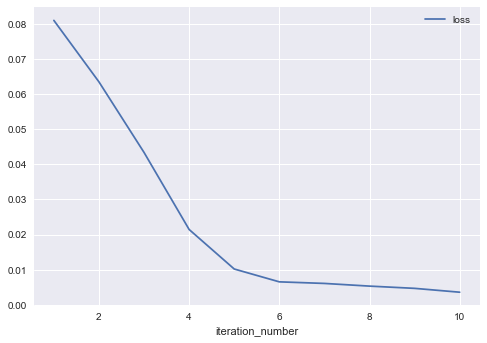

In [11]:
# Plotting the convergence of the loss function metric
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

metrics = job.metrics()

df = pd.DataFrame(metrics)

plt.style.use("seaborn")
df.sort_values(by=["iteration_number"]).plot(x="iteration_number", y="loss")

In `qcbm_job.py`, we called `save_job_result({"params": params.tolist()})
` to save the optimal parameters that minimized the loss function.
Importantly, we can plot the predicted probability distribution vs the target probability from the data. To do so, we first import the QCBM locally again, but now we initialize it with the parameters returned from our job.

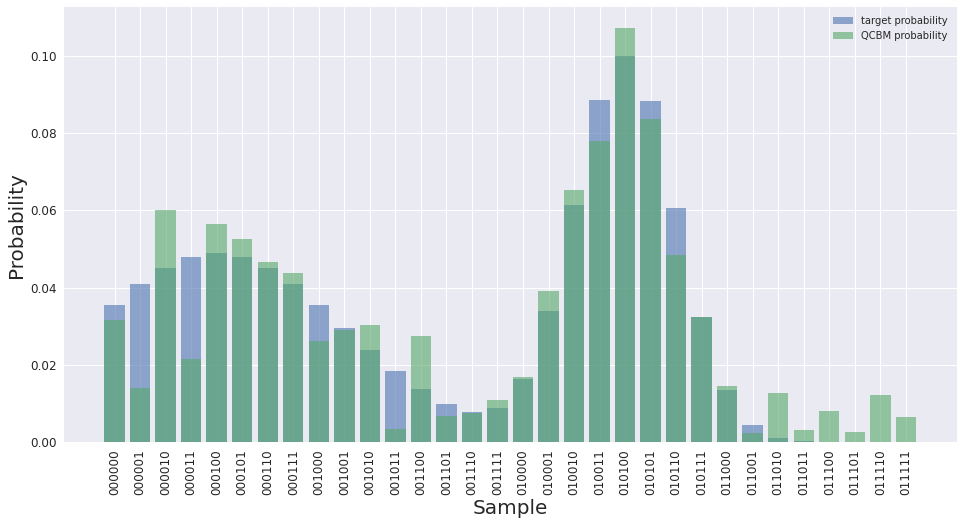

In [12]:
# Plotting the original probability distribution, and the QCBM prediction probability
from braket.devices import LocalSimulator
from qcbm.qcbm import QCBM

device = LocalSimulator()
qcbm = QCBM(device, n_qubits, 3, data)

qcbm_probs = qcbm.probabilities(np.array(job.result()["params"]))

labels = ["{0:{fill}6b}".format(i, fill='0') for i in range(len(data))]

plt.bar(range(2 ** n_qubits), data, label="target probability", alpha=0.6)
plt.bar(range(2 ** n_qubits), qcbm_probs, label="QCBM probability", alpha=0.6)
plt.xticks([i for i in range(len(data))], labels, rotation='vertical', size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.legend()
plt.show()

Great! As expected, the QCBM probability distribution closes matches the target distribution. 

In [13]:
print("Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 11140000, 'tasks': {'COMPLETED': 1114}, 'execution_duration': 36.416, 'billed_execution_duration': 3342.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 4.1775 USD


## Running different hyperparameters

One of the strengths of Braket Jobs is the ability to submit and monitor many jobs simultaneously. We can use this to perform a grid search to find good hyperparameters. Below we initialize 4 unique jobs with different `n_layers`.

In [14]:
jobs = []
names = []

for n_layers in range(1, 5):
    print(f"Creating job with {n_layers} layers")
    name = f"hyper-param-job-{n_qubits}-{n_layers}-" + str(int(time.time()))
    hyperparams = {
        "n_qubits": str(n_qubits), 
        "n_layers": str(n_layers), 
        "n_iterations": str(10),  
        "local": "False"
    }

    tmp_job = AwsQuantumJob.create(
        device="arn:aws:braket:::device/quantum-simulator/amazon/sv1",
        source_module="qcbm",
        entry_point="qcbm.qcbm_job:main",
        job_name=name,
        hyperparameters=hyperparams,
        input_data="data.npy",
        wait_until_complete=False,
    )
    jobs.append(tmp_job)
    names.append(name)

Creating job with 1 layers
Creating job with 2 layers
Creating job with 3 layers
Creating job with 4 layers


To check the results, we could load the results as we did before, or we could check the "Monitor" tab in the Braket Jobs dashboard in the AWS Console.

<div align="center"><img src="console_figures/hp_job_console.png"/></div>

In [15]:
%%time 
# this cell should take 20 min
jobs[-1].result(); # wait for the last job to finish

CPU times: user 655 ms, sys: 55.4 ms, total: 711 ms
Wall time: 20min 13s


{'params': [0.10582521466656217,
  0.6586736197367999,
  1.200696637224605,
  0.4795713744652507,
  0.0328225561013912,
  0.1416309729268562,
  -0.5345646198096557,
  1.0538623482363394,
  0.7051532697159473,
  1.1289212962111743,
  0.3252133525383767,
  1.35930000770726,
  0.6822907707251727,
  0.12822412303073896,
  0.05970880743338971,
  -0.12872775118257376,
  -0.01491068861101457,
  0.32288291810762443,
  0.718775541054627,
  0.5784806341360708,
  0.7367894357120217,
  0.11594024932187227,
  0.733472297708508,
  -0.026719234290999323,
  0.7264773526906863,
  0.7325621363172037,
  -0.046684249654940044,
  0.39342685130747507,
  0.5008300653892479,
  -0.029208732236774993,
  0.3555730806594967,
  0.3701310167636944,
  -0.11995921589574741,
  1.5015116657129093,
  1.4200581102942063,
  1.3390578795535855,
  -0.05630286546508683,
  0.5891673890248028,
  0.23324096170351397,
  -0.09559073124226201,
  0.3409907544669093,
  0.0033502886823119516,
  0.06831464166264858,
  0.85913752038010

We can also load the jobs directly from their job arns. 

We can now plot the results from all the hyperparameters experiments once they finish. If the cell below does not work, wait a few minutes for metrics to load and try again.

In [16]:
dfs = []
for i, j in enumerate(jobs):
    df = pd.DataFrame(j.metrics())
    df.sort_values(by=["iteration_number"])
    dfs.append(df)

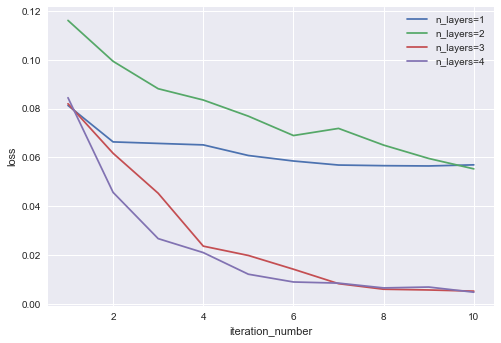

In [17]:
for i, df in enumerate(dfs):
    plt.plot(df["iteration_number"], df["loss"], label=f"n_layers={i+1}")
plt.legend()
plt.xlabel("iteration_number")
plt.ylabel("loss")
plt.show()

For the plots above, we see that the loss is much lower for `n_layers=3` and `n_layers=4`. We can conclude for 5 qubits, we need at least 3 layers in the QCBM to accurately learn the two-peak Gaussian data. 

In [18]:
for job in jobs:
    print("Task Summary")
    print(job.result()['task summary'])
    print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
    print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 4550000, 'tasks': {'COMPLETED': 455}, 'execution_duration': 16.96, 'billed_execution_duration': 1365.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 1.70625 USD
Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 8780000, 'tasks': {'COMPLETED': 878}, 'execution_duration': 33.115, 'billed_execution_duration': 2634.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not fac

## Conclusion 

In this notebook, we submitted a single training job in Amazon Braket Hybrid Jobs. We then simultaneously submitted 4 new jobs with different hyperparameters to learn about the number of layers required in our circuit.

## References


[1] Benedetti, Marcello, Delfina Garcia-Pintos, Oscar Perdomo, Vicente Leyton-Ortega, Yunseong Nam, and Alejandro Perdomo-Ortiz. “A Generative Modeling Approach for Benchmarking and Training Shallow Quantum Circuits.” Npj Quantum Information 5, no. 1 (May 27, 2019): 1–9. https://doi.org/10.1038/s41534-019-0157-8.

[2] Liu, Jin-Guo, and Lei Wang. “Differentiable Learning of Quantum Circuit Born Machine.” Physical Review A 98, no. 6 (December 19, 2018): 062324. https://doi.org/10.1103/PhysRevA.98.062324.
